# Setup

In [ ]:
!pip install -qU transformers accelerate bitsandbytes diffusers

In [ ]:
# Standard library imports
import gc
import os

# Deep learning and model-related imports
import torch
from transformers import T5EncoderModel
from diffusers import (
    FluxPipeline,
    FluxTransformer2DModel,
)

# Image processing imports
from PIL import Image

# access
from huggingface_hub import login
from google.colab import userdata

Z biblioteki standardowej Pythona kod importuje dwa moduły:
- `gc` służący do zarządzania garbage collectorem (automatycznym systemem zwalniania pamięci)
- `os` zapewniający interfejs do funkcji systemu operacyjnego

Następnie importowane są komponenty związane z głębokim uczeniem:
- `torch` - główna biblioteka do tworzenia i trenowania sieci neuronowych
- `T5EncoderModel` z biblioteki transformers - model encodera oparty na architekturze T5
- Z biblioteki diffusers importowany jest `FluxPipeline` oraz `FluxTransformer2DModel` - są to komponenty służące do generowania i przekształcania obrazów

Na końcu zaimportowany zostaje moduł do podstawowej obróbki obrazów:
- `Image` z biblioteki PIL (Python Imaging Library) - zapewnia funkcje do wczytywania, zapisywania i prostego przetwarzania plików graficznych

In [ ]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
login(token = userdata.get('HF_TOKEN'))

In [ ]:
class CFG:
  enc = "sayakpaul/flux.1-dev-nf4-pkg"
  sub = "text_encoder_2"
  pipe = "black-forest-labs/FLUX.1-dev"
  dtype = torch.float16

Przyjrzyjmy się każdemu elementowi konfiguracji:

`enc` wskazuje na konkretną wersję modelu tekstowego: "sayakpaul/flux.1-dev-nf4-pkg". Sufiks "nf4" w nazwie wskazuje, że model został poddany kwantyzacji 4-bitowej, o której mówiliśmy wcześniej. Jest to model opracowany przez użytkownika "sayakpaul" i należy do rodziny modeli FLUX.1.

`sub` o wartości "text_encoder_2" określa, który konkretny komponent modelu chcemy załadować. Nazwa wskazuje, że jest to drugi enkoder tekstowy w architekturze systemu. Jest to istotne, ponieważ złożone modele często składają się z wielu podkomponentów, z których każdy może być przechowywany w osobnym podkatalogu.

`pipe` wskazuje na główny model "FLUX.1-dev" od zespołu black-forest-labs. Jest to kompletny pipeline do przetwarzania obrazów, podczas gdy wcześniejsze parametry odnosiły się do jego poszczególnych komponentów.

# Funkcje


In [ ]:
def flush():
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
      torch.cuda.reset_max_memory_allocated()
      torch.cuda.reset_peak_memory_stats()

flush()

Ta część kodu definiuje i natychmiast wywołuje funkcję `flush()`, która służy do zarządzania pamięcią podczas pracy z modelami PyTorch na GPU.

Funkcja wykonuje cztery kluczowe operacje związane z czyszczeniem pamięci:

`gc.collect()` uruchamia Pythonowy garbage collector, który usuwa z pamięci RAM obiekty, które nie są już używane. Jest to jak sprzątanie mieszkania - wyrzucamy rzeczy, których już nie potrzebujemy.

`torch.cuda.empty_cache()` zwalnia nieużywaną pamięć GPU zarezerwowaną przez PyTorch. Możemy to porównać do opróżniania kosza na śmieci w systemie operacyjnym - pamięć została oznaczona jako "do usunięcia", ale fizycznie nadal była zajęta, dopóki nie wykonaliśmy tej operacji.

`torch.cuda.reset_max_memory_allocated()` resetuje licznik maksymalnej zaalokowanej pamięci GPU. To jak wyzerowanie licznika w samochodzie przed rozpoczęciem nowej podróży - pozwala nam śledzić zużycie pamięci od tego momentu.

`torch.cuda.reset_peak_memory_stats()` resetuje statystyki szczytowego użycia pamięci GPU. Jest to bardziej kompleksowy reset wszystkich statystyk pamięci, nie tylko maksymalnej alokacji.

Wywołanie `flush()` na końcu powoduje natychmiastowe wykonanie wszystkich tych operacji. Jest to dobra praktyka przed rozpoczęciem pracy z dużymi modelami uczenia maszynowego, ponieważ zapewnia czysty start i minimalizuje ryzyko problemów z pamięcią podczas późniejszych operacji.

# Modele dyfuzyjne dla GPU poor

In [ ]:
text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    CFG.enc, subfolder= CFG.sub )

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Ta linia kodu służy do wczytania modelu T5EncoderModel w wersji zoptymalizowanej pod kątem pamięci. Przeanalizujmy dokładnie, co się tutaj dzieje.

Metoda `from_pretrained()` to standardowy sposób ładowania wstępnie wytrenowanych modeli w bibliotece transformers. Działa ona jak pobieranie gotowego, wyspecjalizowanego narzędzia - zamiast trenować model od zera, korzystamy z już przygotowanej, sprawdzonej wersji.

Pierwszy argument `CFG.enc` wskazuje na konkretny model: "sayakpaul/flux.1-dev-nf4-pkg". Nazwa ta zawiera kilka istotnych informacji:
- "sayakpaul" to autor lub organizacja, która udostępniła model
- "flux.1" wskazuje na rodzinę modeli FLUX w wersji 1
- "nf4" oznacza, że model został poddany kwantyzacji 4-bitowej
- "pkg" sugeruje, że jest to spakowana wersja modelu

Parametr `subfolder=CFG.sub` o wartości "text_encoder_2" wskazuje, że interesuje nas konkretny komponent modelu - drugi enkoder tekstowy. Jest to jak wskazanie konkretnego narzędzia w większym zestawie narzędzi.

Warto zwrócić uwagę na znaczenie kwantyzacji 4-bitowej. W normalnych warunkach parametry modelu są przechowywane jako liczby 32-bitowe, co zapewnia wysoką precyzję, ale zajmuje dużo pamięci. Kwantyzacja do 4 bitów oznacza, że każdy parametr jest reprezentowany przez zaledwie 4 bity zamiast 32. To drastyczna redukcja - model zajmuje około 8 razy mniej pamięci. Jest to jak kompresja pliku - tracimy trochę jakości, ale zyskujemy możliwość pracy z modelem na urządzeniach o ograniczonej pamięci.

Wynik operacji jest zapisywany w zmiennej `text_encoder_2_4bit`, która będzie używana w dalszej części kodu do przetwarzania tekstu wejściowego. Model ten będzie odpowiedzialny za przekształcanie tekstu w reprezentacje numeryczne, które mogą być dalej przetwarzane przez system.

In [ ]:
pipeline = FluxPipeline.from_pretrained(
    CFG.pipe,
    text_encoder_2 = text_encoder_2_4bit,
    transformer=None, vae=None,
    torch_dtype = CFG.dtype,
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Ten fragment kodu tworzy i konfiguruje główny potok przetwarzania (pipeline) modelu FLUX, który będzie odpowiedzialny za wykonywanie zadań związanych z przetwarzaniem obrazów. Przeanalizujmy go dokładnie, żeby zrozumieć każdy element.

Najpierw tworzony jest pipeline za pomocą metody `from_pretrained()`. Jest to jak składanie zaawansowanej maszyny z gotowych komponentów. Metoda przyjmuje kilka ważnych parametrów:

`CFG.pipe` wskazuje na bazowy model "black-forest-labs/FLUX.1-dev". Jest to fundament, na którym będziemy budować nasz system.

`text_encoder_2` otrzymuje wcześniej załadowany model `text_encoder_2_4bit`. Ten enkoder jest odpowiedzialny za przetwarzanie tekstu wejściowego. Zauważmy, że używamy tu naszej zoptymalizowanej 4-bitowej wersji, co jest kluczowe dla efektywnego zarządzania pamięcią.

Parametry `transformer=None` i `vae=None` są ustawione na None, co oznacza, że te komponenty nie będą używane. Jest to jak wyłączenie niektórych modułów w większej maszynie - upraszczamy system do wersji z jednym enkoderem.

`torch_dtype = CFG.dtype` ustawia typ danych na float16, co oznacza użycie 16-bitowej precyzji dla liczb zmiennoprzecinkowych. Jest to kolejny element strategii optymalizacji pamięci - choć nie tak radykalny jak 4-bitowa kwantyzacja enkodera.

Po utworzeniu pipeline'u, wywołujemy na nim metodę `enable_model_cpu_offload()`. Jest to bardzo istotny krok w kontekście zarządzania pamięcią. Metoda ta włącza mechanizm, który pozwala na przenoszenie nieużywanych części modelu z pamięci GPU do pamięci RAM. Możemy to porównać do systemu zarządzania pamięcią w komputerze, który przenosi rzadziej używane dane na dysk twardy, aby zwolnić cenną pamięć RAM dla aktywnie używanych procesów. W tym przypadku, zamiast dysku twardego używamy pamięci RAM, a zamiast RAM-u - pamięci GPU.

Całość tworzy zoptymalizowany system, który może efektywnie działać nawet na urządzeniach z ograniczoną pamięcią GPU, dzięki zastosowaniu różnych technik oszczędzania pamięci: kwantyzacji 4-bitowej, precyzji float16 i dynamicznego przenoszenia modelu między CPU a GPU.

In [ ]:
flush()

In [ ]:
prompt = "High-definition, cinematic, full-body photograph of a North European middle aged doctor in her office"

with torch.no_grad():
    print("Encoding prompts.")
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
        prompt=prompt, prompt_2=None, max_sequence_length=256
    )

pipeline = pipeline.to("cpu")
del pipeline

flush()

Encoding prompts.


Ten fragment kodu pokazuje proces kodowania opisu tekstowego (promptu) na format zrozumiały dla modelu sztucznej inteligencji. Przeanalizujmy go krok po kroku, aby zrozumieć, co dokładnie się tutaj dzieje.

Najpierw definiujemy prompt, który opisuje pożądany obraz: "High-definition, cinematic, full-body photograph of a North European middle aged doctor in her office". Jest to szczegółowy opis, który ma pokierować model w generowaniu konkretnego typu obrazu - wysokiej jakości, kinowego ujęcia przedstawiającego lekarkę w średnim wieku w jej gabinecie.

Następnie rozpoczynamy proces kodowania tego opisu. Używamy konstrukcji `with torch.no_grad():`, która jest istotnym elementem optymalizacji. Mówi ona systemowi PyTorch, żeby nie śledził gradientów podczas wykonywania tych operacji. Jest to jak wyłączenie systemu monitorowania w fabryce podczas rutynowej operacji - nie potrzebujemy szczegółowych pomiarów, więc możemy zaoszczędzić zasoby wyłączając ten system.

Wewnątrz tego bloku wywołujemy metodę `pipeline.encode_prompt()`. Jest to kluczowy moment transformacji, gdzie tekst zamienia się w formę numeryczną. Metoda przyjmuje kilka parametrów:
- `prompt` to nasz główny opis
- `prompt_2=None` wskazuje, że nie używamy dodatkowego, drugiego opisu
- `max_sequence_length=256` określa maksymalną długość sekwencji - to jak ustalenie górnej granicy liczby słów, które będziemy przetwarzać

Metoda zwraca trzy elementy:
- `prompt_embeds` - główne embeddingi, czyli numeryczne reprezentacje naszego tekstu
- `pooled_prompt_embeds` - zagregowane embeddingi
- `text_ids` - identyfikatory tekstu

Po zakończeniu kodowania wykonujemy kilka kroków czyszczenia:

1. `pipeline = pipeline.to("cpu")` przenosi cały pipeline z GPU na CPU. Jest to jak przeniesienie ciężkiego sprzętu z warsztatu do magazynu po zakończeniu pracy.

2. `del pipeline` całkowicie usuwa pipeline z pamięci. To jak posprzątanie warsztatu po skończonej pracy - zwalniamy miejsce na kolejne operacje.

3. Na końcu wywołujemy funkcję `flush()`, którą poznaliśmy wcześniej. Wykonuje ona kompleksowe czyszczenie pamięci, zarówno na CPU jak i GPU, upewniając się, że system jest gotowy na kolejne zadania.

Ta sekwencja operacji pokazuje, jak ważne jest nie tylko wykonanie głównego zadania (kodowanie promptu), ale także odpowiednie zarządzanie zasobami systemu. Każdy krok jest przemyślany pod kątem efektywności i optymalizacji użycia pamięci.

In [ ]:
# ładujemy swantyzowany pipeline
transformer_4bit = FluxTransformer2DModel.from_pretrained(CFG.enc, subfolder = "transformer")

pipeline = FluxPipeline.from_pretrained(
    CFG.pipe,
    text_encoder = None,
    text_encoder_2 = None,
    tokenizer = None,
    tokenizer_2 = None,
    transformer = transformer_4bit,
    torch_dtype = CFG.dtype,
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Ten fragment kodu pokazuje proces ładowania i konfiguracji nowego pipeline'u, tym razem koncentrując się na komponencie transformera. Jest to kolejny etap w naszym systemie przetwarzania obrazów.

W pierwszym kroku ładujemy skwantyzowany model transformera:
```python
transformer_4bit = FluxTransformer2DModel.from_pretrained(CFG.enc, subfolder = "transformer")
```
To działanie przypomina wyjęcie z pudełka specjalnie zoptymalizowanej części maszyny. Model jest w wersji 4-bitowej, co oznacza, że jego parametry są przechowywane w bardzo kompaktowej formie. Wyobraźmy sobie, że standardowy model to książka zapisana pełnymi zdaniami, a nasza wersja 4-bitowa to ta sama książka zapisana za pomocą skrótów - zajmuje znacznie mniej miejsca, zachowując najważniejsze informacje.

Następnie tworzymy nowy pipeline, ale z zupełnie inną konfiguracją niż poprzednio:
```python
pipeline = FluxPipeline.from_pretrained(
    CFG.pipe,
    text_encoder = None,
    text_encoder_2 = None,
    tokenizer = None,
    tokenizer_2 = None,
    transformer = transformer_4bit,
    torch_dtype = CFG.dtype,
)
```

Zauważmy kluczowe różnice: tym razem wyłączamy wszystkie komponenty związane z przetwarzaniem tekstu (enkodery i tokenizery), ustawiając je na None. Jest to jak wyłączenie wszystkich modułów odpowiedzialnych za rozumienie języka w naszym systemie. Zamiast tego, skupiamy się na transformerze - komponencie, który będzie odpowiedzialny za faktyczne przetwarzanie i generowanie obrazów.

Ustawienie `torch_dtype = CFG.dtype` ponownie określa precyzję liczb zmiennoprzecinkowych na 16 bitów, co jest kolejnym elementem strategii optymalizacji pamięci. To jak znalezienie złotego środka między dokładnością a efektywnością - nie potrzebujemy pełnej precyzji 32-bitowej, ale chcemy zachować wystarczającą dokładność do naszych celów.

Na końcu włączamy mechanizm offloadingu do CPU:
```python
pipeline.enable_model_cpu_offload()
```
Jest to jak włączenie inteligentnego systemu zarządzania zasobami, który może przenosić nieużywane części modelu z pamięci GPU do pamięci RAM, gdy nie są aktywnie używane. To szczególnie ważne przy pracy z dużymi modelami na urządzeniach o ograniczonej pamięci GPU.

Ta konfiguracja tworzy wyspecjalizowany pipeline, który jest zoptymalizowany pod kątem przetwarzania obrazów, wykorzystując wcześniej przygotowane embeddingi tekstowe. Jest to przykład modułowego podejścia do budowy systemu sztucznej inteligencji, gdzie każdy komponent jest starannie dobrany i skonfigurowany pod kątem swojego konkretnego zadania.

# Test


In [ ]:
print("Running denoising.")
height, width = 512, 768
images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=50,
    guidance_scale=5.5,
    height=height,
    width=width,
    output_type="pil",
).images
images[0].save("output.png")

Running denoising.


  0%|          | 0/50 [00:00<?, ?it/s]

Ten fragment kodu pokazuje finalny etap procesu - generowanie obrazu na podstawie wcześniej przygotowanego opisu. Jest to moment, w którym wszystkie wcześniejsze przygotowania się materializują.

Na początku ustawiamy rozmiary generowanego obrazu: wysokość 512 pikseli i szerokość 768 pikseli. Te proporcje (około 2:3) są typowe dla zdjęć portretowych, co dobrze pasuje do naszego celu - stworzenia zdjęcia lekarki w gabinecie.

Następnie wywołujemy pipeline z szeregiem precyzyjnie dobranych parametrów. Każdy z nich ma istotny wpływ na proces generacji:

`prompt_embeds` i `pooled_prompt_embeds` to nasze wcześniej przygotowane reprezentacje numeryczne opisu. Możemy je porównać do szczegółowej instrukcji dla artysty, zapisanej w języku, który model potrafi zrozumieć.

`num_inference_steps=50` określa liczbę kroków w procesie generacji obrazu. Jest to jak proces malowania obrazu - im więcej kroków, tym więcej szczegółów i poprawek można nanieść. 50 kroków to rozsądny kompromis między jakością a czasem generacji. Przy mniejszej liczbie kroków obraz mógłby być mniej dopracowany, przy większej - czas generacji niepotrzebnie by się wydłużył.

`guidance_scale=5.5` to parametr określający, jak ściśle model ma trzymać się naszego opisu. Wartość 5.5 oznacza umiarkowanie silne prowadzenie - model ma pewną swobodę twórczą, ale nie może zbytnio odbiegać od zadanego opisu. To jak instrukcje dla artysty - nie są sztywnym nakazem, ale wyraźnie określają oczekiwania.

`output_type="pil"` wskazuje, że chcemy otrzymać obraz w formacie obsługiwanym przez bibliotekę PIL (Python Imaging Library). Jest to format, który łatwo można zapisać do pliku lub dalej przetwarzać.

Na końcu zapisujemy wygenerowany obraz do pliku "output.png". Używamy pierwszego (i w tym przypadku jedynego) obrazu z listy `images[0]`, ponieważ model może teoretycznie wygenerować więcej niż jeden obraz na raz.

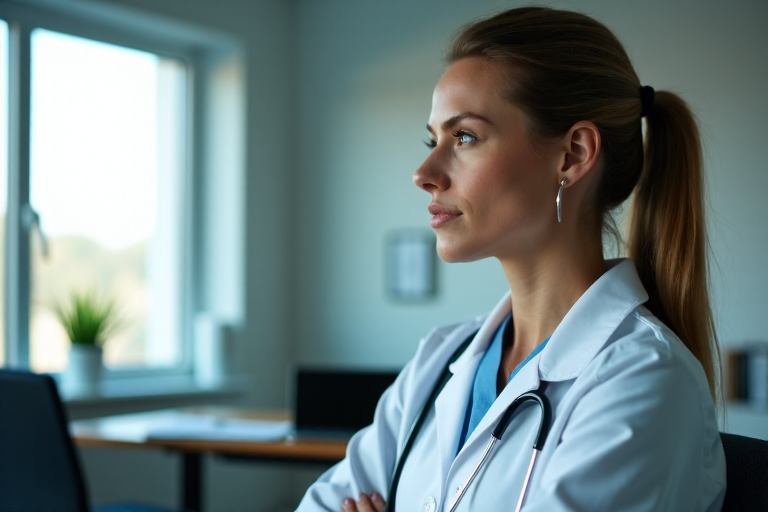

In [ ]:
Image.open("output.png")